In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import threading

from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from IPython.display import display, clear_output

%matplotlib inline
%load_ext cython

## L63 System - Ensemble

### setup

In [2]:
%%cython
# copy past some ODE solver in cython

cimport cython
import numpy as np
cimport numpy as np


cdef class Problem(object):
    cdef int N
    cdef double[:] dudt

    def __init__(self, int N):
        self.N = N
        self.dudt = np.zeros(N)

    cpdef double[:] rhs(self, double[:] u, double t):
        return np.zeros(self.N)

cdef class Method(object):
    cdef int N
    cdef double[:] step_result
    cdef double[:] rhs

    def __init__(self, N):
        self.N = N
        self.step_result = np.zeros((N,), dtype=np.double)
        self.rhs = np.zeros((N,), dtype=np.double)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void step(self, double[:,::1] result, int i, int j, Problem f, double t, double dt):
        pass

cdef class MethodRK4(Method):
    cdef double[:] k1
    cdef double[:] k2
    cdef double[:] k3
    cdef double[:] tmp
    cdef double* k1p
    cdef double* k2p
    cdef double* k3p
    cdef double* tmpp

    def __init__(self, N):
        super(MethodRK4, self).__init__(N)
        self.k1 = np.zeros((N,), dtype=np.double)
        self.k2 = np.zeros((N,), dtype=np.double)
        self.k3 = np.zeros((N,), dtype=np.double)
        self.tmp = np.zeros((N,), dtype=np.double)
        self.k1p = &self.k1[0]
        self.k2p = &self.k2[0]
        self.k3p = &self.k3[0]
        self.tmpp = &self.tmp[0]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void step(self, double[:,::1] result, int i, int j, Problem f, double t, double dt):
        cdef double *pptr = &result[j, 0]
        cdef double *rptr = &result[i, 0]
        cdef double* tmp = &f.rhs(result[j, :], t)[0]

        # compute k1 and the next step
        for n in range(self.N):
            self.k1p[n] = dt * tmp[n]
            self.tmpp[n] = pptr[n] + 0.5 * self.k1p[n]

        # compute k2 and the next step
        tmp = &f.rhs(self.tmp, t + 0.5 * dt)[0]
        for n in range(self.N):
            self.k2p[n] = dt * tmp[n]
            self.tmpp[n] = pptr[n] + 0.5 * self.k2p[n]

        # compute k3 and the next step
        tmp = &f.rhs(self.tmp, t + 0.5 * dt)[0]
        for n in range(self.N):
            self.k3p[n] = dt * tmp[n]
            self.tmpp[n] = pptr[n] + self.k3p[n]

        # compute k4 and combine into result
        tmp = &f.rhs(self.tmp, t + dt)[0]
        for n in range(self.N):
            rptr[n] = pptr[n] + 1.0/6.0 * (
                    self.k1p[n] + 2.0 * self.k2p[n] + 2.0 * self.k3p[n] + dt * tmp[n])


@cython.boundscheck(False)
@cython.cdivision(True)
cdef double[:,:] __ODEsolve(Method method, Problem f, double a, double b, int N, double[::1] yInit):
    cdef double dt = (b - a) / N
    cdef double[:,::1] result = np.zeros((N+1, f.N), dtype=np.double)

    result[0, :] = yInit

    cdef double t
    cdef int i
    for i in range(1, N+1):
        t = a + i * dt
        method.step(result, i, i-1, f, t, dt)

    return result

cpdef double[:,:] ODEsolve(Problem f, double a, double b, int N, double[::1] yInit):
    cdef Method method = MethodRK4(f.N)
    return __ODEsolve(method, f, a, b, N, yInit)

cdef class L63(Problem):
    cdef double[:] para
    
    def __init__(self, double[:] para):
        super(L63, self).__init__(3)
        self.para = para

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cpdef double[:] rhs(self, double[:] u, double t):
        self.dudt[0] = self.para[0] * (u[1] - u[0])
        self.dudt[1] = -u[0] * u[2] + self.para[2] * u[0] - u[1]
        self.dudt[2] = u[0] * u[1] - self.para[1] * u[2]
        return self.dudt

In [4]:
# def some functions to handle the solver

class ODE_Solution(object):
    def __init__(self, t, y):
        self.t = t
        self.y = y

def solve_L63(p=np.array([10., 8./3., 13.926]), u0=[1,0,0], t_stop=100, t_steps=100_000):
    a = 0
    b = t_stop
    N = t_steps
    t = np.linspace(a, b, N+1)
    u0 = np.asarray(u0, dtype=float)
    solution = ODEsolve(L63(p), a, b, N, u0)
    
    return ODE_Solution(t, solution)

def solve_L63_ensemble(p=np.array([10., 8./3., 13.926]), t_stop=100, t_steps=100_000, u0s=[[1,0,0]]):
    solutions = []
    for u0 in u0s:
        solutions.append(solve_L63(p=p, u0=u0, t_stop=t_stop, t_steps=t_steps))
    return solutions

In [5]:
# def functions to construct the ensembles

def sphere_ensemble(R, N=1000, u0=[0,0,0]):
    out = []
    for i in range(N):
        l = random.uniform(0, 1)
        v = random.uniform(-1, 1)
        phi = random.uniform(0, 2 * np.pi)
        
        d = [R * l**(1/3) * np.sqrt(1-v**2) * np.cos(phi),
             R * l**(1/3) * np.sqrt(1-v**2) * np.sin(phi),
             R * l**(1/3) * v]
        
        u = [sum(x) for x in zip(u0, d)]
                
        out.append(u)
    return out

def disk_ensemble(R, N=1000, u0=[0,0,0]):
    out = []
    for i in range(N):
        r = random.uniform(0, R**2)
        theta = random.uniform(0, 2 * np.pi)
        
        x = np.sqrt(r) * np.cos(theta)
        y = np.sqrt(r) * np.sin(theta)
        
        u = [sum(X) for X in zip(u0, [x, y, 0])]
                
        out.append(u)
    return out

def ring_ensemble(R, N=1000, u0=[0,0,0]):
    out = []
    for i in range(N):
        phi = random.uniform(0, 2 * np.pi)

        x = R * np.cos(phi)
        y = R * np.sin(phi)
        z = 0
        
        u = [sum(a) for a in zip(u0, [x, y, z])]
                
        out.append(u)
    return out 

In [6]:
# function to generate 3d animation of ensemble

def animamtion_3d_ensemble(sols, label='ensemble'):
    clear_output(wait=True)
    display(label)

    x_lim = (-30,30)
    z_lim = (-30,40)
    y_lim = (-30,30)

    t = np.array([np.ones(len(sols))*i for i in range(len(sols[0].t))]).flatten()
    u_1 = []
    u_2 = []
    u_3 = []
    for i in range(len(sols[0].t)):
        for sol in sols:
            u_1.append(sol.y[i,0])
            u_2.append(sol.y[i,1])
            u_3.append(sol.y[i,2])

    df = pd.DataFrame({"time": t ,"x" : u_1, "y" : u_2, "z" : u_3})

    def update_graph(num):
        data=df[df['time']==num]
        graph._offsets3d = (data.x, data.y, data.z)
        graph_12._offsets3d = (data.x, data.y, [z_lim[0]]*len(data.z))
        graph_23._offsets3d = ([x_lim[0]]*len(data.x), data.y, data.z)
        graph_31._offsets3d = (data.x, [y_lim[1]]*len(data.y), data.z)
        title.set_text('{}, time={:.2f}'.format(label, num/100))
        clear_output(wait=True)
        display(num)


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)
    ax.set_zlim(*z_lim)

    ax.set_xlabel('$u_1$')
    ax.set_ylabel('$u_2$')
    ax.set_zlabel('$u_3$')
    title = ax.set_title(label)

    data=df[df['time']==0]
    graph = ax.scatter(data.x, data.y, data.z, marker='.', s=1, color='red')
    graph_12 = ax.scatter(data.x, data.y, z_lim[0], marker='.', s=1, color='.5')
    graph_23 = ax.scatter(x_lim[0], data.y, data.z, marker='.', s=1, color='.5')
    graph_31 = ax.scatter(data.x, y_lim[1], data.z, marker='.', s=1, color='.5')

    ani = animation.FuncAnimation(fig, update_graph, len(sols[0].t),
                                   interval=10, blit=False)

    ani.save('gifs/d3_{}.mp4'.format(label), fps=25, dpi=80, extra_args=['-vcodec', 'libx264'], writer='ffmpeg')
    plt.show()

### a)

In [7]:
def u_fix(r, b=8./3.):
    u_0 = [0, 0, 0]
    u_p = [ np.sqrt(b * (r - 1)),  np.sqrt(b * (r - 1)), r - 1]
    u_m = [-np.sqrt(b * (r - 1)), -np.sqrt(b * (r - 1)), r - 1]
    return [u_0, u_p, u_m]

def solve_and_animate_ensemble(r=22.5, b=8./3., Pr=10., form='sphere', R=1e-6, u_0=[0,0,0], N_points=1000, t_steps=1000, t_stop=10.):
    label = '{}_R_{:.1e}_r_{:.1f}_b_{:.1f}_u0_{:.1f}_{:.1f}_{:.1f}'.format(form, R, r, b, u_0[0], u_0[1], u_0[2])
    if form == 'sphere':
        solutions = solve_L63_ensemble(p=np.array([Pr, b, r]), t_stop=t_stop, t_steps=t_steps, u0s=sphere_ensemble(R, N_points, u_0))
    elif form == 'disk':
        solutions = solve_L63_ensemble(p=np.array([Pr, b, r]), t_stop=t_stop, t_steps=t_steps, u0s=disk_ensemble(R, N_points, u_0))
    elif form == 'ring':
        solutions = solutions = solve_L63_ensemble(p=np.array([Pr, b, r]), t_stop=t_stop, t_steps=t_steps, u0s=ring_ensemble(R, N_points, u_0))
    else:
        print('{} unkown'.format(form))
        return
    animamtion_3d_ensemble(solutions, label=label)

In [7]:
# set parameters

b = 8./3.
Pr = 10.
r = 25.5

N_points = 1_000
t_steps = 1_000
t_stop = 100

R = 1.
u_0 = u_fix(r,b)[1]

form = 'disk'

args = {'r':r, 'Pr':Pr, 'b':b, 'N_points':N_points, 't_steps':t_steps, 't_stop':t_stop, 'R':R, 'u_0':u_0, 'form':form}

0

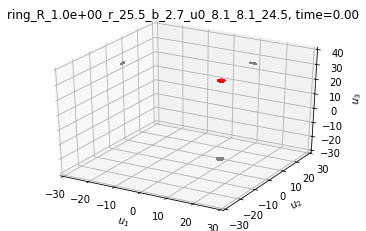

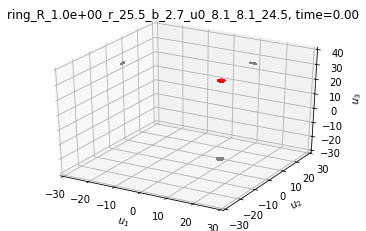

In [8]:
threads = []

for x in ['ring', 'sphere']:
    _args = args
    _args['form'] = x
    t = threading.Thread(target=solve_and_animate_ensemble, kwargs=_args)
    threads.append(t)
    t.start()

for t in threads:
    t.join()